# Large attachment failures in requesting TPP practices

Questions:

- Can we reliably identify GP2GP conversations that have failed due to TPP’s attachment size constraints?
- For such conversations, can we identify the size of the largest attachment?
- Given a proposed attachment size limit, can we estimate the number of transfer failures that will occur due to breaching this limit?
- Are there any trends in attachment size that may impact on our findings in the future? (e.g. is there a trend for attaching larger files to patient records?)

In [1]:
import paths
%load_ext autoreload
%autoreload 2

## Coverage of large message failures in the MI data

- We know that the MI data isn't always reliable
- We believe that by comparing large message error volumes in MI and in spine, we should be able to get some insight into the value of the MI data for addressing these issues

### According to Spine

NMS query to retrieve all large message errors from spine (regardless of whether generated by the sender or the requestor):
```
index="spine2-live" service="gp2gp" ackExceptionCode=30
| stats count, dc(conversationID) as distinct_conversations
```

Running this query for 1st May - 31st May 2019 gave:

```
count: 1092
distinct_conversations: 1053
```

That is, there were `1092` spine messages with `ackExceptionCode = 30` (i.e. Application Acknowledgement messages with `large message general failures` according to the gp2gp spec), and these occurred over `1053` unique conversations.

TODO:

- codes `29` and `31` are also associated with large message errors -- do we see any of these in practice? associated with TPP?

### According to the MI data

For the MI data, we have both the 'sender' and 'requestor' views of each conversation.  All the following queries run for May 1st - May 31st 2019.

#### From the sender perspective - looking at request acknowledgement errors

```
index="gp2gp-mi" sourcetype="gppractice-SR" RequestAckCode=30
| stats count, dc(ConversationID) as distinct_conversations
```

Results:
```
count: 683
distinct_count: 683
```

#### From the requestor perspective - looking at request errors

```
index="gp2gp-mi" sourcetype="gppractice-RR" RequestErrorCode=30
| stats count, dc(ConversationID) as distinct_conversations
```

Results:

```
count: 659
distinct_conversations: 649
```

#### From the requestor perspective - looking at extract acknowledgement errors

```
index="gp2gp-mi" sourcetype="gppractice-RR" ExtractAckCode=30
| stats count, dc(ConversationID) as distinct_conversations
```

Results:

```
count: 352
distinct_count: 352
```

#### Merging all of the above:

```
index="gp2gp-mi" sourcetype="gppractice-SR" RequestAckCode=30
| append [index="gp2gp-mi" sourcetype="gppractice-RR" ExtractAckCode=30]
| append [index="gp2gp-mi" sourcetype="gppractice-RR" RequestErrorCode=30]
| stats dc(eval(upper(ConversationID))) as distinct_conversations
```

Results:

```
distinct_conversations: 1035
```

This is very close to the spine results --- the discrepancy may be plausibly explained by the lag in MI reporting.

Conclusion: we can be confident in using the MI data to analyse 'error code 30' events --- i.e. `large message general failures`.

## Large message failures involving TPP attachment limits

```
index="gp2gp-mi" sourcetype="gppractice-RR"
| eval key=RegistrationTime + "-" + RegistrationSmartcardUID
| eval month=substr(RegistrationTime, 6, 2)
| rex ": (?<attachment_size>\d+) is larger than TPP limit"
| eval attachment_size_mb=attachment_size / (1024 * 1024)
| search attachment_size=*
| table key, month, RequestorODS, attachment_size_mb
```

In [2]:
import pandas as pd
import numpy as np
from IPython.display import display
import matplotlib.pyplot as plt

In [3]:
import data

In [4]:
attachment_sizes_df = pd.read_csv(
    data.PRMT_372_attachment_sizes.path,
)

In [5]:
attachment_sizes_df.columns

Index(['key', 'month', 'RequestorODS', 'attachment_size_mb'], dtype='object')

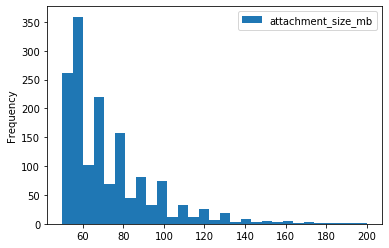

In [6]:
(attachment_sizes_df[["attachment_size_mb"]]
 .plot.hist(bins=np.linspace(50, 200, 150/5))
);

## GP2GP outcomes based on MI data for TPP practices

Preliminary notes:

- The number of registration events that terminate in an unambiguous 'general large message failure' is nowhere near the total number of 'failures' observed in requesting TPP practices in PRMT-365.
  => Need to get the numbers and show here
- Digging deeper into this, most of the 'failures' in PRMT-365 were 0-xx type: that is, no acknowledgement was ever sent (and in particular, no explicit *failure* was reported in the MI data).
- Picking a specific practice (M85046), and look in detail at failures of this kind in the `spine2-live` dataset indicated that often an 'Extract acknowledgement' message *was* sent in spine, but the details of this message were not recorded in the MI spec.
- Also, in a large number of the registration events looked at in this way, the ExtractAcks were sent on the same date (2019-05-14), despite the original request being made on different days, typically much earlier in the month (05-02 to 05-09).

This suggests that we need to follow up in more detail with TPP on conditions in which they do not record ExtractAck message details in MI.

It also suggests that we can't easily determine the actual rate of failures from the MI data, at least for TPP practices --- I'm *much* less confident in the MI data as a result of this exploration.

```
search index="gp2gp-mi" sourcetype="gppractice-RR"
| eval key=RegistrationTime + "-" + RegistrationSmartcardUID
| lookup GP2GP-Practice-Lookup PracticeCode AS RequestorODS OUTPUTNEW CurrentClinicalSupplier as requestor_supplier
```